In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   rotation_range=5,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [3]:
train_dataset  = train_datagen.flow_from_directory(directory = './DATASET/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22968 images belonging to 7 classes.


In [4]:
valid_dataset = valid_datagen.flow_from_directory(directory = './DATASET/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


In [5]:
test_dataset = test_datagen.flow_from_directory(directory = './DATASET/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


In [6]:
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

In [7]:
for layer in base_model.layers[:-4]:
    layer.trainable=False

In [8]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

In [10]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [11]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [12]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [13]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [14]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 30,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/30
359/359 [==============================] - 1409s 4s/step - loss: 1.9570 - accuracy: 0.8542 - precision: 0.1864 - recall: 0.0061 - auc: 0.5870 - f1_score: 0.0113 - val_loss: 1.8495 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6373 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/30
359/359 [==============================] - 1417s 4s/step - loss: 1.8364 - accuracy: 0.8569 - precision: 0.4135 - recall: 0.0043 - auc: 0.6319 - f1_score: 0.0083 - val_loss: 1.8280 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6428 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/30
359/359 [==============================] - 1434s 4s/step - loss: 1.8029 - accuracy: 0.8571 - precision: 0.4994 - recall: 0.0177 - auc: 0.6487 - f1_score: 0.0337 - val_loss: 1.8270 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6415 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/30
359/359 [=====

Epoch 27/30
359/359 [==============================] - 716s 2s/step - loss: 1.7330 - accuracy: 0.8611 - precision: 0.6504 - recall: 0.0602 - auc: 0.6858 - f1_score: 0.1097 - val_loss: 1.8931 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5613 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 28/30
359/359 [==============================] - 718s 2s/step - loss: 1.7215 - accuracy: 0.8626 - precision: 0.6896 - recall: 0.0691 - auc: 0.6897 - f1_score: 0.1251 - val_loss: 1.8796 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5667 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 29/30
359/359 [==============================] - 1466s 4s/step - loss: 1.7205 - accuracy: 0.8622 - precision: 0.6754 - recall: 0.0677 - auc: 0.6909 - f1_score: 0.1226 - val_loss: 1.8399 - val_accuracy: 0.8573 - val_precision: 1.0000 - val_recall: 0.0012 - val_auc: 0.6057 - val_f1_score: 0.0025 - lr: 0.0010
Epoch 30/30
359/359 [===============

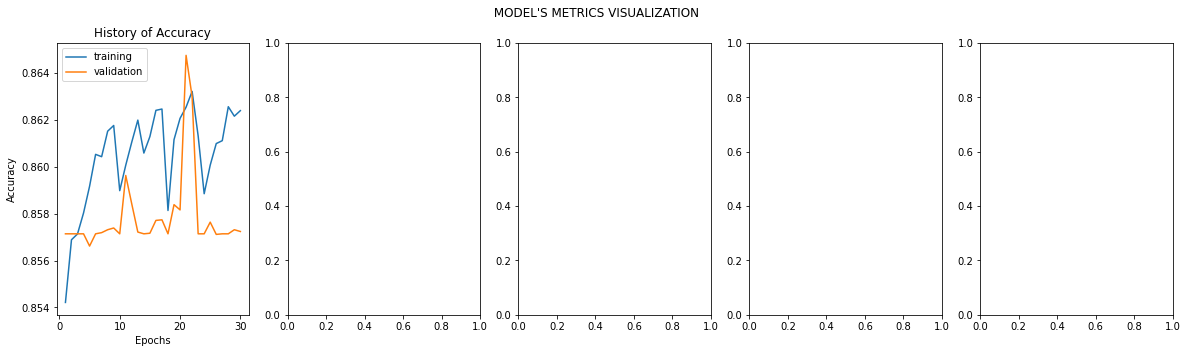

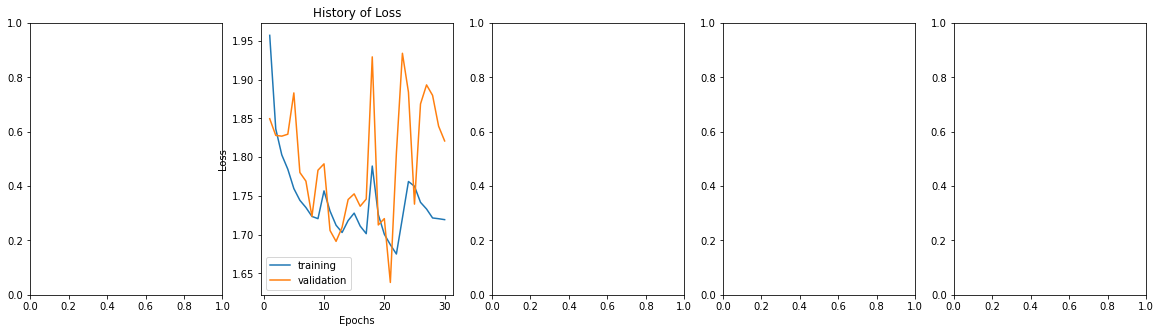

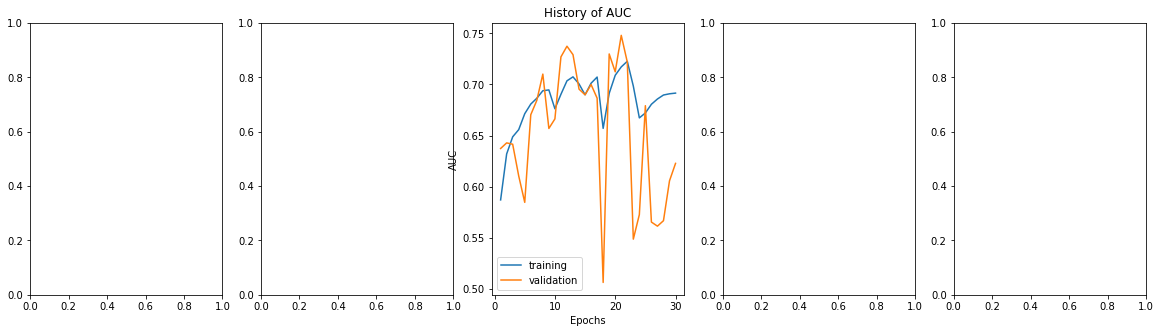

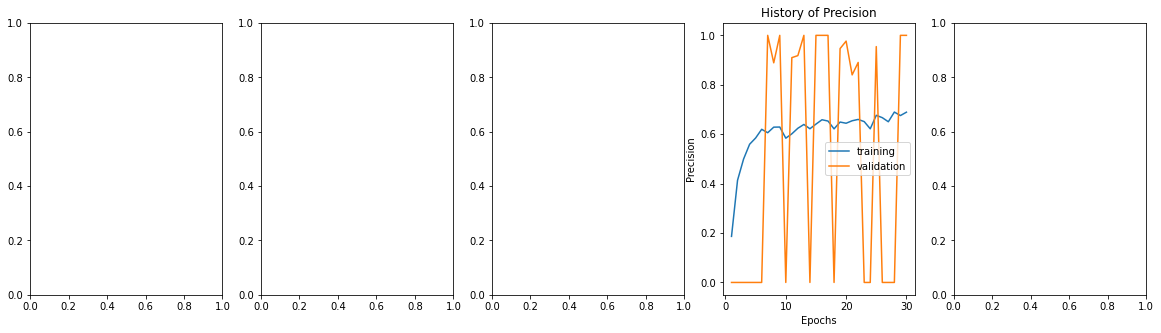

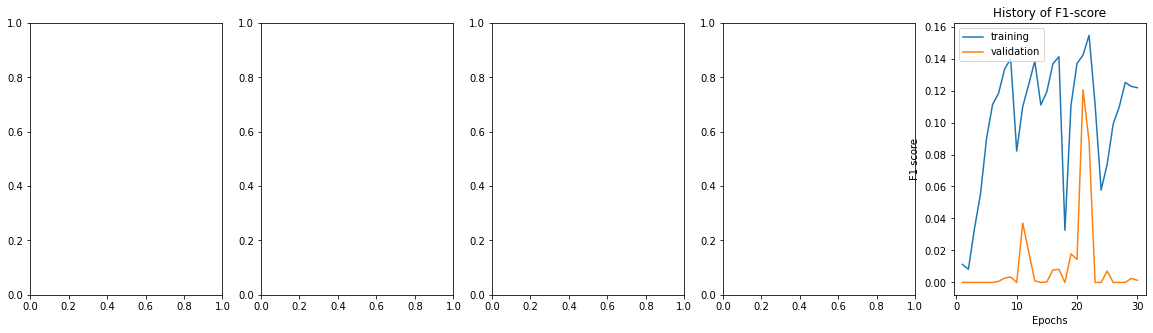

In [19]:
def Train_Val_Plot1(acc,val_acc):
    
    fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])

def Train_Val_Plot2(loss,val_loss):
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
def Train_Val_Plot3(auc,val_auc):  
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
def Train_Val_Plot4(precision,val_precision):
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
def Train_Val_Plot5(f1,val_f1):    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot1(history.history['accuracy'],history.history['val_accuracy']
              )
Train_Val_Plot2(
               history.history['loss'],history.history['val_loss']
               
              )
Train_Val_Plot3(
               history.history['auc'],history.history['val_auc']
               
              )
Train_Val_Plot4(
               history.history['precision'],history.history['val_precision']
              )
Train_Val_Plot5(
               history.history['f1_score'],history.history['val_f1_score']
              )
